# Home Assignment 1
Due by 8th May, 2024 at 23:59 CEST

Students:
* Hauke Schüle, 10004972
* Jannik Jahn, 

In [119]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

## Neural Network Basics

We want to create a 2 layer NN, which means we want to calculate  $y = W_2 * ReLU(W_1 * x + b_1) + b_2$

Complete the TODOs below to create such a NN.

Since you will be needing to compute the gradients w.r.t. all parameters, you may look into online resources for help. Please cite or link any online recources you do use.

You are allowed to change any existing parts, however the code has to remain easy to understand and well documented.

In [120]:
def relu(x):
    """
    ReLU activation function
    
    Parameters:
        x (np.ndarray): numpy array with shape (m, n) where m is the number of dimensions and n is the number of points
        
    Returns:
        x' (np.ndarray): return value of the pointwise ReLU application
    """
    r = x.copy()
    for element in np.nditer(r, op_flags=['readwrite']):
        if element < 0:
            element[...] = 0
        else:
            element[...] = element
    return r


def relu_grad(x):
    r_grad = x.copy()
    for element in np.nditer(r_grad, op_flags=['readwrite']):
        if element <= 0:
            element[...] = 0
        else:
            element[...] = 1
    return r_grad

def sigmoid(x):
    """
    Sigmoid activation function
    Parameters:
        x (np.ndarray): numpy array with shape (m, n) where m is the number of dimensions and n is the number of points
    Returns:
        x' (np.ndarray): return value of the pointwise sigmoid application
    """
    return 1 / (1 + np.exp(-x))

In [121]:
class NumPyNeuralNet:
    
    def __init__(self, dim_in, dim_hidden, dim_out):
        self.dim_in = dim_in
        self.dim_hidden = dim_hidden
        self.dim_out = dim_out
        
        self.W_1 = np.random.randn(dim_in, dim_hidden) # weight matrix for first layer
        self.W_2 = np.random.randn(dim_hidden, dim_out) # weight matrix for second layer
        self.b_1 = np.random.randn(1, dim_hidden) # bias for first layer, shape (1, n) for easy matrix addition
        self.b_2 = np.random.randn(1, dim_out) # bias for second layer, shape (1, n) for easy matrix addition
        
        
    def predict(self, x):
        """
        Calculates the output of the neural network for the given x.
        
        Parameters:
            x (np.ndarray): input value numpy array
        
        Returns:
            y (np.ndarray): predicted output for `x`
        """
        if x.shape != (1, self.dim_in):
            raise ValueError(f"Input dimension {x.shape} does not match the expected input dimension {(1, self.dim_in)}")
        hidden = relu((x @ self.W_1) + self.b_1)
        output = hidden @ self.W_2 + self.b_2
        return output
    
    
    def loss(self, x, y):
        """
        Calculates the Mean-Squared Error and returns the gradients w.r.t. to the parameters.
        
        Parameters:
            x (np.ndarray): input value numpy array with shape (self.dim_in, n)
            y (np.ndarray): ground truth value numpy array with shape (self.dim_out, n)
            
        Returns:
            loss (float): Mean-Squared-Error between predicted value on input points and ground truth value
            W_1_grad (np.ndarray): gradient w.r.t W_1   
            W_2_grad (np.ndarray): gradient w.r.t W_2  
            b_1_grad (np.ndarray): gradient w.r.t b_1   
            b_2_grad (np.ndarray): gradient w.r.t b_2   
        """
        # make sure that the input and output dimensions are correct
        if x.shape != (1, self.dim_in):
            raise ValueError(f"Input dimension {x.shape} does not match the expected input dimension {(1, self.dim_in)}")
        if y.shape != (1, self.dim_out):
            raise ValueError(f"Ground truth dimension {y.shape} does not match the expected output dimension {(1, self.dim_out)}")
        y_pred = self.predict(x)

        if y_pred.shape != y.shape:
            raise ValueError(f"Predicted shape {y_pred.shape} does not match the expected shape {y.shape}")
        
        # calculate the loss
        loss = 0.5 * np.mean(np.square(y_pred - y)) # Mean Squared Error with 1/2 factor for easier gradient calculation
        
        # calculate the gradients
        l_grad = y_pred - y # gradient of the loss w.r.t. the output
        l_grad = np.clip(l_grad, -5, 5) # clip the gradient to avoid exploding gradients
        h = x @ self.W_1 + self.b_1
        r = relu(h)
        r_grad = relu_grad(h)

        b_2_grad = np.array(l_grad)
        W_2_grad = r.T @ l_grad
        b_1_grad = l_grad @ self.W_2.T * r_grad
        W_1_grad = x.T @ (l_grad @ self.W_2.T * r_grad)

        return loss, W_1_grad, W_2_grad, b_1_grad, b_2_grad

    
    def update(self, W_1_grad, W_2_grad, b_1_grad, b_2_grad, lr=0.001):
        """
        Update the parameters of the neural network with the gradients.
        
        Parameters:
            W_1_grad (np.ndarray): gradient w.r.t W_1
            W_2_grad (np.ndarray): gradient w.r.t W_2
            b_1_grad (np.ndarray): gradient w.r.t b_1
            b_2_grad (np.ndarray): gradient w.r.t b_2
            lr (float): learning rate, default: 0.001
        """
        self.W_1 -= lr * W_1_grad
        self.W_2 -= lr * W_2_grad
        self.b_1 -= lr * b_1_grad
        self.b_2 -= lr * b_2_grad

         
    def train(self, x, y, lr=0.001, epochs=1000):
        """
        Train the neural network with gradient descent.
        
        Parameters:
            x (np.ndarray): input values
            y (np.ndarray): ground truth values
            lr (float): learning rate, default: 0.001
            epochs (int): number of epochs to train, default: 1000
            
        Returns:
            loss (float): Return the loss achieved after all epochs
        """
        loss_history = []
        # for every epoch
        for i in tqdm(range(epochs)):
            # for every sample in the dataset
            loss_eopch = [] # plot the mean loss for every epoch
            for j in range(x.shape[0]): # x shape is to be expected as (n, 1, dim_in). n samples in the dataset with the extra dimension for easier matrix multiplication
                x_j = x[j]
                y_j = y[j]
                loss, W_1_grad, W_2_grad, b_1_grad, b_2_grad = self.loss(x_j, y_j)
                self.update(W_1_grad, W_2_grad, b_1_grad, b_2_grad, lr)
                loss_eopch.append(loss)
            loss_history.append(np.mean(loss_eopch))
            lr = lr * 0.99 # decay the learning rate for faster convergence and more stable training
        plt.plot(loss_history)
        plt.ylabel("Loss")
        plt.xlabel("Epochs")
        plt.title("Average Loss over epochs")
        plt.show()
        return loss_history[-1] # return the final loss



100%|██████████| 1000/1000 [01:14<00:00, 13.38it/s]


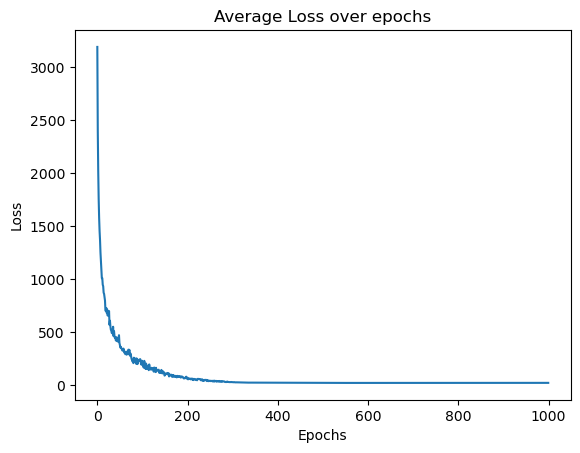

Final loss: 20.047822941085826


In [ ]:
# We test the model created above on the simple function y = x^2

model = NumPyNeuralNet(1, 20, 1)

# Create a randomly distributed array of 1000 values
x_train = 10 * np.random.randn(1000, 1, 1)
# Create ground truth by calculating x*x
y_train = np.expand_dims([[x_train[i][0][0] * x_train[i][0][0]] for i in range(x_train.shape[0])], axis=1)

loss = model.train(x_train, y_train, lr=0.001, epochs=1000)
print(f"Final loss: {loss}")

# Got 1000 samples with 1000 epochs working by clipping the gradients and decaying the learning rate

100%|██████████| 30/30 [00:00<00:00, 251.72it/s]


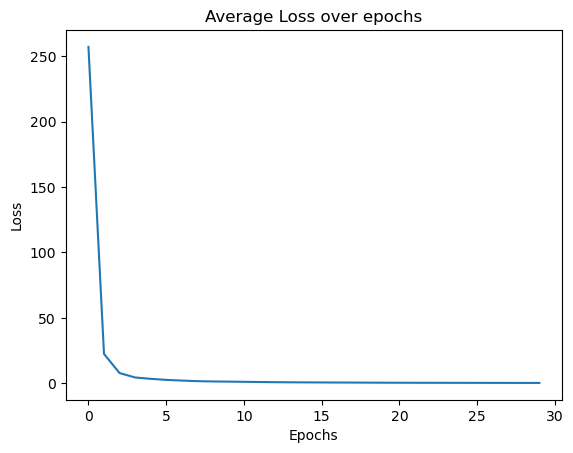

x_train shape: (50, 1, 4)
y_train shape: (50, 1, 2)
y_train: [[[  0.80581319  -2.56986332]]

 [[ -7.48993133   2.34341348]]

 [[ -0.7401756    2.31691979]]

 [[ -1.63375985  -0.05704903]]

 [[ 12.89827865  -6.47166139]]

 [[  1.2751773   -2.05691945]]

 [[  7.96388213  -1.81080747]]

 [[  2.9400564   -7.10753446]]

 [[  0.53262513   2.49062925]]

 [[  4.86357933  -5.35824708]]

 [[  6.55814405  -2.36941621]]

 [[ -3.76415287   9.81168048]]

 [[ -1.84896156  -8.69808317]]

 [[ -1.60785553   3.78626808]]

 [[ -6.17749033  11.07509311]]

 [[  5.39315523   1.98819639]]

 [[ -2.86553906  -4.42180661]]

 [[  6.30971544  -3.55582321]]

 [[ -0.89013991  -4.78180182]]

 [[ -9.92775723   8.75692691]]

 [[  8.53430267   0.33817902]]

 [[  7.85490657   0.25004176]]

 [[ -3.6730591    1.85098534]]

 [[-10.67931846  12.55814651]]

 [[ -1.48748755  10.60110822]]

 [[ -0.78428684 -10.13573754]]

 [[ -2.58454612   1.16265174]]

 [[-11.07413043 -10.97210981]]

 [[  4.20307269  -3.05483033]]

 [[ -5.5175

In [123]:
# test the model on more than one input dimension and with reasonable number of epochs and samples on a simple function

model = NumPyNeuralNet(4, 20, 2)

x_train = 4 * np.random.randn(50, 1, 4)
y_train = np.expand_dims([[x_train[i][0][0] + x_train[i][0][1], x_train[i][0][2] + x_train[i][0][3]] for i in range(x_train.shape[0])], axis=1)

loss = model.train(x_train, y_train, lr=0.001, epochs=30)
print(f"x_train shape: {x_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_train: {y_train}")
x_test = 2 * np.random.randn(1, 4)
y_test = np.array([[x_test[0][0] + x_test[0][1], x_test[0][2] + x_test[0][3]]])
print(f"x_test {x_test}")
print(f"Predicted: {model.predict(x_test)}")
print(f"Expected: {y_test}")
print(f"Final loss: {loss}")

## Embeddings

### Intrinsic evaluation of embeddings
Word similarity task is often used as an intrinsic evaluation criteria. In the dataset file you will find a list of word pairs with their similarity scores as judged by humans. The task would be to judge how well are the word vectors aligned to human judgement. We will use word2vec embedding vectors trained on the google news corpus. (Ignore the pairs where at least one the words is absent in the corpus)

In [124]:
import torch.nn as nn
import torch
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import gensim.downloader as api
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd
import scipy.stats as stats
import os
from tqdm import tqdm

In [125]:
wv = api.load('word2vec-google-news-300')

Write a function which takes as input two words and computes the cosine similarity between them.
You do not need to implement the cosine similarity calculation from scratch. Feel free to use any Python library.
Remeber to ignore any pairs where at least one word is absent in the corpus. (2 points)

In [126]:
def similarity(word1, word2):
    """
    Calculate the cosine similarity between two words.
    
    Parameters:
        word1 (str): first word
        word2 (str): second word
        
    Returns:
        sim (float): cosine similarity between the two words
    """
    if word1 not in wv.key_to_index or word2 not in wv.key_to_index:
        print(f"One of the words '{word1}' or '{word2}' is not in the vocabulary.")
        return None
    sim = cosine_similarity(wv[word1].reshape(1, -1), wv[word2].reshape(1, -1))
    return sim[0][0]

Compute the similarity between all the word pairs in the list and sort them based on the similarity scores. (1 point)

In [127]:
df = pd.read_csv("wordsim353_dataset.csv")
df['similarity_score'] = df.apply(lambda row: similarity(row['word_1'], row['word_2']), axis=1)

In [128]:
df.sort_values(by='similarity_score', ascending=False, inplace=True)
word_pairs_cosine_similarity = list(zip(df['word_1'].tolist(), df['word_2'].tolist()))
print(word_pairs_cosine_similarity[:10])
print(df.head(10))

[('tiger', 'tiger'), ('Harvard', 'Yale'), ('man', 'woman'), ('football', 'soccer'), ('mile', 'kilometer'), ('vodka', 'brandy'), ('journey', 'voyage'), ('football', 'basketball'), ('type', 'kind'), ('championship', 'tournament')]
           word_1      word_2  human_mean  similarity_score
2           tiger       tiger       10.00          1.000000
209       Harvard        Yale        8.13          0.781770
306           man       woman        8.30          0.766401
42       football      soccer        9.03          0.731355
170          mile   kilometer        8.66          0.725848
59          vodka      brandy        8.13          0.688149
68        journey      voyage        9.29          0.683085
43       football  basketball        6.81          0.668247
236          type        kind        8.97          0.666641
296  championship  tournament        8.36          0.665532


Sort the word pairs in the list based on the human judgement scores. (1 point)

In [129]:
df.sort_values(by='human_mean', ascending=False, inplace=True)
word_pairs_human_mean = list(zip(df['word_1'].tolist(), df['word_2'].tolist()))
print(word_pairs_human_mean[:10])
print(df.head(10))

[('tiger', 'tiger'), ('fuck', 'sex'), ('midday', 'noon'), ('journey', 'voyage'), ('dollar', 'buck'), ('money', 'cash'), ('coast', 'shore'), ('money', 'cash'), ('money', 'currency'), ('football', 'soccer')]
       word_1    word_2  human_mean  similarity_score
2       tiger     tiger       10.00          1.000000
40       fuck       sex        9.44          0.223392
73     midday      noon        9.29          0.552741
68    journey    voyage        9.29          0.683085
266    dollar      buck        9.22          0.256212
31      money      cash        9.15          0.615122
70      coast     shore        9.10          0.508367
97      money      cash        9.08          0.615122
98      money  currency        9.04          0.160101
42   football    soccer        9.03          0.731355


Compute spearman rank correlation between the two ranked lists obtained in the previous two steps.
You do not need to implement the spearman rank correlation calculation from scratch. Feel free to use any Python library. (2 points)

In [130]:
print(f"len word_pairs_cosine_similarity: {len(word_pairs_cosine_similarity)}")
print(f"len word_pairs_human_mean: {len(word_pairs_human_mean)}")

len word_pairs_cosine_similarity: 353
len word_pairs_human_mean: 353


In [131]:
df_ranked = df.copy()
df_ranked['rank_cosine_similarity'] = df_ranked['similarity_score'].rank(ascending=False)
df_ranked['rank_human_mean'] = df_ranked['human_mean'].rank(ascending=False)
df_ranked.head()

,word_1,word_2,human_mean,similarity_score,rank_cosine_similarity,rank_human_mean
2,tiger,tiger,10.00,1.000000,1.0,1.0
40,fuck,sex,9.44,0.223392,200.0,2.0
73,midday,noon,9.29,0.552741,34.0,3.5
68,journey,voyage,9.29,0.683085,7.0,3.5
266,dollar,buck,9.22,0.256212,173.0,5.0


In [132]:
# Calculate the Spearman correlation between the similarity score ranks and the human mean ranks
correlation, p_value = stats.pearsonr(df_ranked['rank_cosine_similarity'], df_ranked['rank_human_mean'])
print(f"Spearman correlation: {correlation:.4f}, p-value: {p_value:.4f}")

Spearman correlation: 0.7000, p-value: 0.0000


In [133]:
# Calculate the Spearman correlation between the similarity scores and human mean ratings
correlation, p_value = stats.pearsonr(df['similarity_score'], df['human_mean'])
print(f"Spearman correlation: {correlation:.4f}, p-value: {p_value:.4f}")

Spearman correlation: 0.6525, p-value: 0.0000


### Word embedding based clasifier
We will design a simple sentiment classifier based on the pre-trained word embeddings (google news).

Each data point is a movie review and the sentiment could be either positive (1) or negative (0)

In [134]:
import pickle
with open('sentiment_test_X.p', 'rb') as fs:
    test_X = pickle.load(fs)

len(test_X)

1821

In [135]:
with open('sentiment_test_y.p', 'rb') as fs:
    test_y = pickle.load(fs)
    
len(test_y)

1821

In [136]:
test_y[0]

1

In [137]:
with open('sentiment_train_X.p', 'rb') as fs:
    train_X = pickle.load(fs)
with open('sentiment_train_y.p', 'rb') as fs:
    train_y = pickle.load(fs)
with open('sentiment_val_X.p', 'rb') as fs:
    val_X = pickle.load(fs)
with open('sentiment_val_y.p', 'rb') as fs:
    val_y = pickle.load(fs)        

Given a review, compute its embedding by averaging over the embedding of its constituent words. Define a function which given a review as a list of words, generates its embeddings by averaging over the constituent word embeddings. (4 points)

In [138]:
def generate_embedding(review):
    """
    Generate the embedding for a review.
    
    Parameters:
        review (np.ndarray): review to generate the embedding for
        
    Returns:
        embedding (np.ndarray): embedding of the review
    """
    embeddings = []
    for word in review:
        embedding = wv[word] if word in wv.key_to_index else None
        if embedding is not None:
            embeddings.append(embedding)
    return np.mean(embeddings, axis=0) if len(embeddings) > 0 else None

Create a feed-forward network class with pytorch. (Hyperparamter choice such as number of layers, hidden size is left to you) (8 points)

In [149]:
class Classifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(Classifier, self).__init__()
        # We tried two different architectures, one really deep and one with only two layers
        # Both performed quite similar
        self.layers = nn.Sequential(
            # nn.Linear(input_dim, int (hidden_dim/2)),
            # nn.LeakyReLU(0.2),
            # nn.Linear(int (hidden_dim/2), hidden_dim),
            # nn.LeakyReLU(0.2),
            # nn.Linear(hidden_dim, hidden_dim*2),
            # nn.LeakyReLU(0.2),
            # nn.Linear(hidden_dim*2, hidden_dim),
            # nn.LeakyReLU(0.2),
            # nn.Linear(hidden_dim, int (hidden_dim/2)),
            # nn.LeakyReLU(0.2),
            # nn.Linear(int (hidden_dim/2), output_dim),
            # nn.Sigmoid()
            nn.Linear(input_dim, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim, output_dim),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.layers(x)
        return x

Create a Dataset class for efficiently enumerating over the dataset. (3 points)

In [150]:
class sent_data(Dataset):
    def __init__(self, X, y):
        if len(X) != len(y):
            raise ValueError(f"X and y must have the same length. X: {len(X)}, y: {len(y)}")
        self.data = []
        self.labels = []
        for i in range(len(X)):
            embedding = generate_embedding(X[i])
            if embedding is not None:
                self.data.append(embedding)
                self.labels.append(y[i])
        self.data = np.array(self.data)
        self.labels = np.array(self.labels)
        
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        if idx >= len(self.data):
            raise IndexError("Index out of range")
        return self.data[idx], self.labels[idx]

Write a train function to train model. At the end of each epoch compute the validation accuracy and save the model with the best validation accuracy. (12 points)

In [151]:
directory_path = "models"
if not os.path.exists(directory_path):
    os.makedirs(directory_path)
model_path = os.path.join(directory_path, "sentiment_model.pth")

In [152]:
def evaluate(model, test_data):
    """
    Evaluate the model on the test data.
    
    Parameters:
        model (nn.Module): trained model
        test_data (DataLoader): test data loader
        
    Returns:
        accuracy (float): accuracy of the model on the test data
    """
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_data:
            outputs = model(inputs.float())
            predicted = (outputs > 0.5).float()
            total += labels.size(0)
            correct += (predicted.squeeze() == labels.float()).sum().item()
    accuracy = correct / total
    print(f"total number of samples validated/tested {total}")
    return accuracy

In [153]:
# Adopt your code to incorporate mini-batch training
# Use cross-entropy as your loss function
def train(model, training_data_loader, validation_data_loader, optimizer, criterion, epochs=5):
    model.train()
    # keep track of the best accuracy
    best_accuracy = 0.0
    for epoch in range(epochs):
        # keep track of the running loss
        running_loss = 0.0
        training_data_loader = tqdm(training_data_loader, desc=f"Epoch: {epoch+1}/{epochs}")
        for i, (inputs, labels) in enumerate(training_data_loader):
            optimizer.zero_grad()
            outputs = model(inputs.float())
            outputs = outputs.squeeze()
            if outputs.shape != labels.shape:
                raise ValueError(f"Output shape {outputs.shape} does not match label shape {labels.shape}")
            loss = criterion(outputs, labels.float())
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            training_data_loader.set_postfix({"loss": running_loss / (i + 1)})
        # evaluate the model on the validation set and save the model if the accuracy is better than the best accuracy
        accuracy = evaluate(model, validation_data_loader)
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            torch.save(model.state_dict(), model_path)
            print(f"Model saved in epoch {epoch+1} with validation accuracy: {best_accuracy:.4f}")

In [154]:
# Hyperparameters
BATCH_SIZE = 32
INPUT_DIMENSION = wv[0].shape[0]
HIDDEN_DIMENSION = 1024
OUTPUT_DIMENSION = 1
LEARNING_RATE = 0.001
EPOCHS = 5

In [155]:
# create datasets and dataloaders 
train_dataset = sent_data(train_X, train_y)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataset = sent_data(val_X, val_y)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_dataset = sent_data(test_X, test_y)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [156]:
# create model, optimizer and loss function with the hyperparameters
# and train the model
model = Classifier(input_dim=INPUT_DIMENSION, hidden_dim=HIDDEN_DIMENSION, output_dim=OUTPUT_DIMENSION)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion = nn.BCELoss()
train(
    model=model, 
    training_data_loader=train_loader, 
    validation_data_loader=val_loader,
    optimizer=optimizer,
    criterion=criterion, 
    epochs=EPOCHS
)

# evaluate the model on the test set
model = Classifier(input_dim=INPUT_DIMENSION, hidden_dim=HIDDEN_DIMENSION, output_dim=OUTPUT_DIMENSION)
model.load_state_dict(torch.load(model_path, weights_only=True))
test_accuracy = evaluate(model, test_loader)
print(f"Test accuracy: {test_accuracy:.4f}")

Epoch: 1/5: 100%|██████████| 217/217 [00:00<00:00, 432.95it/s, loss=0.486]


total number of samples validated/tested 872
Model saved in epoch 1 with validation accuracy: 0.7775


Epoch: 2/5: 100%|██████████| 217/217 [00:00<00:00, 446.85it/s, loss=0.413]


total number of samples validated/tested 872


Epoch: 3/5: 100%|██████████| 217/217 [00:00<00:00, 424.79it/s, loss=0.403]


total number of samples validated/tested 872
Model saved in epoch 3 with validation accuracy: 0.8062


Epoch: 4/5: 100%|██████████| 217/217 [00:00<00:00, 416.65it/s, loss=0.395]


total number of samples validated/tested 872
Model saved in epoch 4 with validation accuracy: 0.8073


Epoch: 5/5: 100%|██████████| 217/217 [00:00<00:00, 417.08it/s, loss=0.383]


total number of samples validated/tested 872
Model saved in epoch 5 with validation accuracy: 0.8085
total number of samples validated/tested 1821
Test accuracy: 0.8144


Evaluate the trained model on the test set and report the test accuracy. (3 points)

In [147]:
# Moved the evaluate method up top to be able to run the whole notebook in one go

In [148]:
model = Classifier(input_dim=INPUT_DIMENSION, hidden_dim=HIDDEN_DIMENSION, output_dim=OUTPUT_DIMENSION)
model.load_state_dict(torch.load(model_path, weights_only=True))
test_accuracy = evaluate(model, test_loader)
print(f"Test accuracy: {test_accuracy:.4f}")

total number of samples validated/tested 1821
Test accuracy: 0.8166
